# Computing the Structure Factor for a Molecular Dynamics Trajectory of Water

The structure factor describes the local structural characteristics in the distribution of atoms in the system. A formula is provided in J. Am. Chem. Soc. 2020, 142, 2868−2875.

For a set of $N$ atoms, the structure factor is a function of wave number $k$ given by

$$S(k)=1 + \frac{1}{N}\sum_{i=1}^{N} \sum_{j\ne i}^{N} \frac{\sin(k r_{ij})}{k r_{ij}} W(r_{ij})$$

where $W(r_{ij}) = \frac{\sin(\pi r_{ij}/r_c)}{\pi r_{ij}/r_c}$. $r_c$ is a cut-off distance.

In the last set of script (v1.0), we tried to develop the code to implement the calculation of structure factor.

Here, we try to interface the structure factor with the classification results from Akanksha.

### Preparation: Installation of Required Packages
1. Install `conda colab`

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


2. Install `mdtraj` package

In [3]:
!conda install -c conda-forge mdtraj

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



## The Code for Computing Structure Factors

#### Import packages

In [4]:
import numpy as np
import itertools
from matplotlib.pyplot import plot

In [5]:
import sys, site, subprocess

print("Kernel Python:", sys.executable)
print("site-packages on sys.path:", [p for p in sys.path if "site-packages" in p])

def ensure_mdtraj():
    # 1) Try normal import
    try:
        import mdtraj as md
        print("mdtraj OK:", md.__version__)
        return md
    except ModuleNotFoundError:
        pass

    # 2) Add common site-packages path where pip said it installed
    candidates = ["/usr/local/lib/python{}.{}".format(sys.version_info.major, sys.version_info.minor) + "/site-packages"]
    # also consider the user site
    try:
        candidates.append(site.getusersitepackages())
    except Exception:
        pass

    for p in candidates:
        if p and p not in sys.path:
            sys.path.insert(0, p)

    try:
        import mdtraj as md
        print("mdtraj OK after sys.path fix:", md.__version__)
        return md
    except ModuleNotFoundError:
        pass

    # 3) Force-install into THIS kernel
    print("Installing mdtraj into this kernel…")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", "--force-reinstall", "mdtraj==1.11.0"])
    import mdtraj as md
    print("mdtraj OK after install:", md.__version__)
    return md

md = ensure_mdtraj()


Kernel Python: /usr/bin/python3.real
site-packages on sys.path: ['/usr/local/lib/python3.12/site-packages']
mdtraj OK: 1.11.0


#### Change working directory

As we will be working with a data file, we need to change the working directory to where the file is.

(1) We mount our google drive folder.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(2) We change the working directory into where the input file is

In [7]:
%cd /content/drive/MyDrive/Shared_Drive/01_Water/102_WaterMLClustering


/content/drive/.shortcut-targets-by-id/1QpmGRuNtR4n8skf4J-5Fv_kbQ6Ymc84I/01_Water/102_WaterMLClustering


In [8]:
!pwd

/content/drive/.shortcut-targets-by-id/1QpmGRuNtR4n8skf4J-5Fv_kbQ6Ymc84I/01_Water/102_WaterMLClustering


#### Load the trajectory and topology files

In [9]:
!ls /content/drive/.shortcut-targets-by-id/1QpmGRuNtR4n8skf4J-5Fv_kbQ6Ymc84I/01_Water/102_WaterMLClustering/Akanksha_Thesis2023/Code/cluster

 cluster.ipynb
 cluster.py
 OrderParam_Run21_swm4ndp_T30.0.mat
 OrderParam_Run21_swm4ndp_T30.0_output.csv
 OrderParam_Run22_swm4ndp_T30.0.mat
 OrderParam_Run22_swm4ndp_T30.0_output.csv
 OrderParam_Run23_swm4ndp_T30.0.mat
 OrderParam_Run23_swm4ndp_T30.0_output.csv
 OrderParamZeta_Run21_swm4ndp_T30.0.mat
 OrderParamZeta_Run22_swm4ndp_T30.0.mat
 OrderParamZeta_Run23_swm4ndp_T30.0.mat
'sample_code_to_run (1).gdoc'
 sample_code_to_run.gdoc
 sample_code_to_run.txt


In [10]:
SimulationFileDirectory = "/content/drive/MyDrive/Shared_Drive/01_Water/WaterData/SimulationData_1024Molecules_supercooled_swm4ndp/SimulationData_1024Molecules_supercooled_swm4ndp/"

import glob
dcdList = glob.glob(SimulationFileDirectory + "/dcd_" + "Run23" + "_swm4ndp_T-20.0_0"+'*.dcd')
dcdList = np.sort(dcdList)
print(dcdList)
topFile = SimulationFileDirectory + "inistate_"+"Run23"+"_swm4ndp_T-20.0.pdb"
print(topFile)

['/content/drive/MyDrive/Shared_Drive/01_Water/WaterData/SimulationData_1024Molecules_supercooled_swm4ndp/SimulationData_1024Molecules_supercooled_swm4ndp/dcd_Run23_swm4ndp_T-20.0_0.dcd']
/content/drive/MyDrive/Shared_Drive/01_Water/WaterData/SimulationData_1024Molecules_supercooled_swm4ndp/SimulationData_1024Molecules_supercooled_swm4ndp/inistate_Run23_swm4ndp_T-20.0.pdb


In [11]:
SimulationFileDirectory = "/content/drive/MyDrive/Shared_Drive/01_Water/WaterData/SimulationData_1024Molecules_supercooled_swm4ndp/SimulationData_1024Molecules_supercooled_swm4ndp/"
dcd_path = SimulationFileDirectory+ "/dcd_" + "Run23" + "_swm4ndp_T-20.0_0"+'*.dcd'
top_path = SimulationFileDirectory+"inistate_"+"Run23"+"_swm4ndp_T-20.0.pdb"


In [12]:
# loading one single file
# dcdFile = dcdList[0]
# traj = md.load_dcd(dcdFile, top=topFile)
# loading multiple trajectories

traj_dcdList = [md.load_dcd(d, top=topFile) for d in dcdList]
traj = md.join(traj_dcdList)
print(traj)
topology = traj.topology

<mdtraj.Trajectory with 1000 frames, 5120 atoms, 1024 residues, and unitcells>


In [13]:
atom_name_to_consider = 'O'
atom_to_consider_indices = [ i  for i in range(topology.n_atoms) if topology.atom(i).name == atom_name_to_consider]
traj_O = traj.atom_slice(atom_to_consider_indices)

In [14]:
traj.unitcell_lengths[0][0]

np.float32(3.1357448)

In [15]:
Lx, Ly, Lz = traj.unitcell_lengths[0] #length unit in x,y,z direction
angles = traj.unitcell_angles[0]   # (alpha, beta, gamma) in degrees
print("frame 0 box (nm):", Lx, Ly, Lz, "angles:", angles)

frame 0 box (nm): 3.1357448 3.1357448 3.1357448 angles: [90. 90. 90.]


In [16]:
import numpy as np

L = traj.unitcell_lengths  # shape: (n_frames, 3), nm
A = traj.unitcell_angles   # shape: (n_frames, 3), degrees

print("box constant across frames?", np.allclose(L, L[0]))
print("angles constant (orthorhombic if ~90°)?", np.allclose(A, A[0]))
print("box at first frame (nm):", L[0])

box constant across frames? True
angles constant (orthorhombic if ~90°)? True
box at first frame (nm): [3.1357448 3.1357448 3.1357448]


## Coding the function to calculate the structure factor

In [17]:
import mdtraj as md
import numpy as np

def load_trajectory(filename):
    traj = md.load(filename)
    return traj

In [18]:
def Si_debye(k_vals, i, f, traj):
    """
    Compute the structure factor S(k) for atom i in frame f.

    Parameters:
    - k_vals: Array of k values to compute
    - i: Atom index
    - f: Frame index
    - traj: MDTraj trajectory object

    Returns:
    - Sk: Computed structure factor values
    """
    N = traj.n_atoms
    r_c = 0.26

    # Compute distances
    ij_list = [[i, j] for j in range(N) if j != i]
    r_ij = md.compute_distances(traj[f], atom_pairs=ij_list)

    # Compute weight function
    Wf = np.pi * r_ij / r_c
    W_ij = np.sin(Wf) / Wf
    W_ij_expanded = np.matmul(np.ones((len(k_vals), 1)), W_ij)

    # Compute S(k)
    k_times_r_ij = np.matmul(k_vals.reshape((len(k_vals), 1)), r_ij)
    sum_factor = (np.sin(k_times_r_ij) / k_times_r_ij) * W_ij_expanded
    Sk = 1 + np.sum(sum_factor, axis=1)  #1/n?

    return Sk

In [26]:
def _sphere_directions(m=96):
    """Quasi-uniform directions on the unit sphere (Fibonacci)."""
    i = np.arange(m) + 0.5
    phi = 2*np.pi * (i / ((1 + np.sqrt(5)) / 2))  # golden-angle-ish
    z = 1 - 2*i/m
    r = np.sqrt(np.maximum(0.0, 1 - z*z))
    return np.stack([r*np.cos(phi), r*np.sin(phi), z], axis=1)

def Si_reciprocal(k_vals, i, f, traj_or_coords, num_dirs=96, center=True):
    """
    Structure factor S(k) averaged over frames i:f and directions on the sphere.
    Accepts:
      - mdtraj.Trajectory (uses .xyz in nm)
      - np.ndarray coords of shape (T,N,3) or (N,3)
    Returns:
      - Sk array with shape (len(k_vals),)
    """
    # Get coords as (T,N,3)
    if hasattr(traj_or_coords, "xyz"):              # mdtraj.Trajectory
        coords = np.asarray(traj_or_coords.xyz, dtype=float)
    else:
        coords = np.asarray(traj_or_coords, dtype=float)
        if coords.ndim == 2 and coords.shape[1] == 3:  # single frame
            coords = coords[None, ...]
        if coords.ndim != 3 or coords.shape[2] != 3:
            raise ValueError("coords must be (T,N,3) or (N,3)")

    T = coords.shape[0]
    # Slice frames; if slice is empty (e.g., single frame), fall back to all
    if isinstance(i, int) and isinstance(f, int) and 0 <= i < f <= T:
        frames = coords[i:f]
    else:
        frames = coords

    if frames.size == 0:
        frames = coords

    N = frames.shape[1]
    dirs = _sphere_directions(num_dirs)  # (D,3)

    Sk = np.zeros(len(k_vals), dtype=float)
    for frame in frames:
        R = frame - frame.mean(axis=0, keepdims=True) if center else frame  # (N,3)
        # For each k, average |rho(k)|^2 over directions
        for idx, k in enumerate(k_vals):
            q = k * dirs                      # (D,3)
            phase = R @ q.T                   # (N,D)
            rho = np.exp(-1j*phase).sum(axis=0)  # (D,)
            Sk[idx] += (np.abs(rho)**2).mean() / N

    Sk /= frames.shape[0]
    return Sk

In [35]:
# Example usage
filename = "/content/drive/MyDrive/Shared_Drive/01_Water/WaterData/SimulationData_1024Molecules_supercooled_swm4ndp/SimulationData_1024Molecules_supercooled_swm4ndp/inistate_Run23_swm4ndp_T-20.0.pdb"  # Change this to your trajectory file
traj = load_trajectory(filename)
k_vals = np.linspace(0.01, 60, 500)

# Compute S(k) for atom 0 in frame 0 as an example
S_k_values = Si_debye(k_vals, i=0, f=0, traj=traj)
S_k_values_2 = S_reciprocal(k_vals, i=0, f=0, traj_or_coords=traj)


[5.11722705e+03 4.67072936e+03 3.64647516e+03 2.43772626e+03
 1.39952649e+03 6.94741580e+02 3.02771894e+02 1.19677981e+02
 4.57815473e+01 1.89101005e+01 9.63608432e+00 6.54399893e+00
 5.66229857e+00 5.54359128e+00 5.49642606e+00 5.16682901e+00
 4.56675026e+00 3.96576637e+00 3.59889203e+00 3.50478309e+00
 3.56844141e+00 3.63711861e+00 3.64924281e+00 3.69007293e+00
 3.89115380e+00 4.29410151e+00 4.83531549e+00 5.40650980e+00
 5.89690304e+00 6.22836220e+00 6.38274494e+00 6.37674592e+00
 6.21253265e+00 5.87493425e+00 5.38289531e+00 4.85071086e+00
 4.48566383e+00 4.46198257e+00 4.76313306e+00 5.18647287e+00
 5.51129283e+00 5.62980604e+00 5.55434104e+00 5.36585634e+00
 5.13906033e+00 4.89809633e+00 4.67695509e+00 4.57099905e+00
 4.62398815e+00 4.70985780e+00 4.65098362e+00 4.43668464e+00
 4.23824489e+00 4.22176988e+00 4.39372743e+00 4.61107288e+00
 4.71031186e+00 4.63861381e+00 4.49761569e+00 4.47611066e+00
 4.69306309e+00 5.05101467e+00 5.27947549e+00 5.19418409e+00
 4.89764047e+00 4.667515

Testing the code for just one frame:

Try to plot the average structure factors for a range of frames.

In [20]:
import matplotlib.pyplot as plt

In [21]:
print(type(traj_O))

<class 'mdtraj.core.trajectory.Trajectory'>


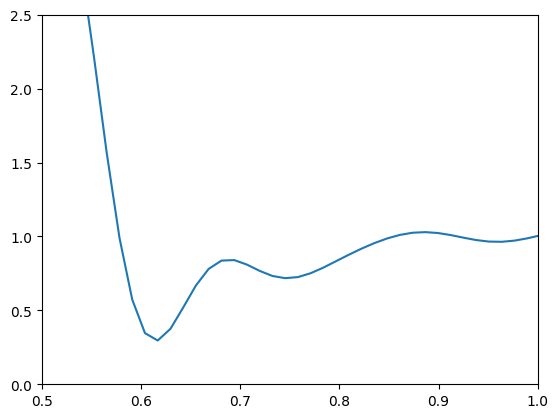

In [36]:
k_vals = np.linspace(0.01, 60, 200)
Sk_avg = Si_debye(k_vals, 0, traj_O.n_frames-1, traj_O)
plt.plot(k_vals*0.26769853/(2*np.pi), Sk_avg)
plt.xlim(0.5,1ho)
plt.ylim(0,2.5)
plt.show()

In [60]:
import sys, subprocess

print("Kernel:", sys.executable)
print("Python:", sys.version)

# 1) Keep only this Python's site-packages on sys.path (drop any 3.11 leftovers)
import sys as _sys
_sys.path = [p for p in _sys.path if "python3.11" not in p]

# 2) Install mutually compatible wheels into THIS kernel
# SciPy 1.14.1 + NumPy 2.0.2 is a stable, compatible pair for Py3.12
subprocess.check_call([sys.executable, "-m", "pip", "install",
                       "--no-cache-dir", "--force-reinstall",
                       "numpy==2.0.2", "scipy==1.14.1"])

# 3) Verify
import numpy, scipy
print("NumPy:", numpy.__version__, "SciPy:", scipy.__version__)

from scipy.io import loadmat
print("scipy.io.loadmat import OK")

Kernel: /usr/bin/python3.real
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy: 2.0.2 SciPy: 1.14.1
scipy.io.loadmat import OK


## Finding the structure factor for one cluster

In [36]:
from scipy.io import loadmat
import pandas as pd
from sklearn import preprocessing, cluster, metrics
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from time import time

from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [46]:
!ls /content/drive/.shortcut-targets-by-id/1QpmGRuNtR4n8skf4J-5Fv_kbQ6Ymc84I/01_Water/102_WaterMLClustering/Diya

'Clustering Clean FINAL_Copy.ipynb'
'Clustering Clean FINAL .ipynb'
'Clustering .ipynb'
 ComputeStructureFactor_v1.0.ipynb
 ComputeStructureFactor_v2.0_Copy.ipynb
 ComputeStructureFactor_v2.0.ipynb
 condacolab_install.log
'Copy of Clustering .ipynb'
 dcd_testMD30.0_0.dcd
 dcd_tip4p2005_T30_N1024_Run01_0.dcd
 DiyaTrial.ipynb
 inistate_testMD30.0.pdb
 inistate_tip4p2005_T30_N1024_Run01.pdb
'Initial research: week 1 and 2.gdoc'
 OrderParam_Run21_swm4ndp_T-20.0.csv
 OrderParam_Run21_swm4ndp_T-20.0.dcd
 OrderParam_Run21_swm4ndp_T-20.0.mat
 OrderParamZeta_Run21_swm4ndp_T-20.0.mat
'Q Data'
 StructureFactor_exploration.ipynb
'Untitled0 (1).ipynb'
 Untitled0.ipynb


In [47]:
%cd /content/drive/.shortcut-targets-by-id/1QpmGRuNtR4n8skf4J-5Fv_kbQ6Ymc84I/01_Water/102_WaterMLClustering/Diya

/content/drive/.shortcut-targets-by-id/1QpmGRuNtR4n8skf4J-5Fv_kbQ6Ymc84I/01_Water/102_WaterMLClustering/Diya


In [48]:

water = loadmat('OrderParam_Run21_swm4ndp_T-20.0.mat')
water1 = loadmat('OrderParamZeta_Run21_swm4ndp_T-20.0.mat')


In [49]:
q_all = []
for i in range(0,20):
    q_all.extend(water['q_all'][i])
Q6_all = []
for i in range(0,20):
    Q6_all.extend(water['Q6_all'][i])
LSI_all = []
for i in range(0,20):
    LSI_all.extend(water['LSI_all'][i])
Sk_all = []
for i in range(0,20):
    Sk_all.extend(water['Sk_all'][i])
zeta_all = []
for i in range(0,20):
  zeta_all.extend(water1['zeta_all'][i])


data = {'q_all': q_all,
        'Q6_all': Q6_all,
        'LSI_all': LSI_all,
        'Sk_all': Sk_all,
        'zeta_all': zeta_all
        }

df = pd.DataFrame(data)

# Scaling the data
scaler = preprocessing.MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
print("Scaled DataFrame columns:", df_scaled.columns)

# K-Means Clustering with 2 clusters
t0 = time()
kmeans = cluster.KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_scaled)
t1 = time()
print(f"KMeans clustering time: {t1 - t0:.2f} sec")

# Add labels to the dataframe
df_scaled['labels'] = labels

# Evaluating the clustering
sil_score = silhouette_score(df_scaled.drop('labels', axis=1), labels)
print(f'Silhouette Score: {sil_score:.4f}')

# loop over frames
for i, frame in enumerate(traj):
    pos = frame.xyz[0]  # shape: (n_atoms, 3), units: nm
    print(f"Frame {i}: positions shape {pos.shape}")
"""
# Plotting pairplot with seaborn
sns.pairplot(df_scaled, hue='labels', markers=["o", "s"])
plt.suptitle("Pairplot of Scaled Data with K-Means Labels", y=1.02)
plt.show()


# Plotting the distributions to see the actual data distribution
plt.figure(figsize=(12, 8))
for i, column in enumerate(df_scaled.columns[:-1], 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df_scaled, x=column, hue='labels', multiple='stack', palette='tab10', kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.suptitle("Distributions of Parameters", y=1.02)
plt.show()


# Plotting original (unscaled) data distributions
plt.figure(figsize=(12, 8))
for i, column in enumerate(df.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=column, kde=True)
    plt.title(f'Distribution of {column} (Unscaled)')
plt.tight_layout()
plt.suptitle("Distributions of Original (Unscaled) Parameters", y=1.02)
plt.show()
"""



Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c2eaec08ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error
Exception ignored on calling ctypes callback function: <functio

Scaled DataFrame columns: Index(['q_all', 'Q6_all', 'LSI_all', 'Sk_all', 'zeta_all'], dtype='object')
KMeans clustering time: 0.39 sec
Silhouette Score: 0.2457
Frame 0: positions shape (5120, 3)


'\n# Plotting pairplot with seaborn\nsns.pairplot(df_scaled, hue=\'labels\', markers=["o", "s"])\nplt.suptitle("Pairplot of Scaled Data with K-Means Labels", y=1.02)\nplt.show()\n\n\n# Plotting the distributions to see the actual data distribution\nplt.figure(figsize=(12, 8))\nfor i, column in enumerate(df_scaled.columns[:-1], 1):\n    plt.subplot(2, 2, i)\n    sns.histplot(data=df_scaled, x=column, hue=\'labels\', multiple=\'stack\', palette=\'tab10\', kde=True)\n    plt.title(f\'Distribution of {column}\')\nplt.tight_layout()\nplt.suptitle("Distributions of Parameters", y=1.02)\nplt.show()\n\n\n# Plotting original (unscaled) data distributions\nplt.figure(figsize=(12, 8))\nfor i, column in enumerate(df.columns, 1):\n    plt.subplot(2, 2, i)\n    sns.histplot(data=df, x=column, kde=True)\n    plt.title(f\'Distribution of {column} (Unscaled)\')\nplt.tight_layout()\nplt.suptitle("Distributions of Original (Unscaled) Parameters", y=1.02)\nplt.show()\n'

In [50]:
# loop over frames
for i, frame in enumerate(traj):
    pos = frame.xyz[0]  # shape: (n_atoms, 3), units: nm
    print(f"Frame {i}: positions shape {pos.shape}")

Frame 0: positions shape (5120, 3)


- kroo is k*r00 (where roo is the avarage distance betweent oxygen) and then divide by 2pi


In [1]:
def structureFactorOfCluster(ClusterData, clusterIndex):
    """
    structureFactorOfCluster(ClusterData, clusterIndex)
    Generates the structure factor of a chosen cluster
    ClusterData = (numpy.array) output from ....
    clusterIndex = (int) the group index of the cluster

    """

    # Find all molecules in cluster 1
    rows, cols = np.where(ClusterData == clusterIndex)

    # k values
    k_min = 0.1
    k_max = 10.0
    num_k_vals = 100
    k_vals = np.linspace(k_min, k_max, num_k_vals)

    # Initialize
    S_k_cluster = np.zeros_like(k_vals)

    # Number of samples (instead of looping directly over all molecules, randomly sample)
    n_pts = 1000

    for _ in range(n_pts):
        idx = np.random.randint(0, len(rows))  # pick a random molecule in the cluster
        f = rows[idx]  # frame
        i = cols[idx]  # molecule index

        S_k_cluster += S_ik_frame(k_vals, i, f, traj_O)

    # Average
    S_k_cluster = S_k_cluster / n_pts

    return S_k_cluster

# Parameters
num_frames = 20
num_molecules = 1024
ClusterData = np.array(labels).reshape((num_frames, num_molecules))

# Getting cluster data
S_k_cluster_1 = structureFactorOfCluster(ClusterData, 1)
S_k_cluster_0 = structureFactorOfCluster(ClusterData, 0)


# Plot
plt.plot(k_vals * 0.26769853 / 2 / np.pi, S_k_cluster_1)
plt.plot(k_vals * 0.26769853 / 2 / np.pi, S_k_cluster_0)
plt.xlabel('k (rescaled)')
plt.ylabel('S(k)')



# Finding the structure factors for molecules in one cluster
num_frames = 20  # Update with the correct number of frames
num_molecules = 1024

ClusterData = np.array(labels).reshape((num_frames, num_molecules))

# Now, np.where should work as expected
rows, cols = np.where(ClusterData == 1)

# find indices for the cluster
rows, cols = np.where(ClusterData == 1)

# initialize an array to store S(k)
k_min = 0.1  # Minimum value of k
k_max = 10.0  # Maximum value of k
num_k_vals = 100  # Number of k values to generate

k_vals = np.linspace(k_min, k_max, num_k_vals)

S_k_cluster = np.zeros(k_vals.shape)


for index in range(len(rows)):
  f = rows[index]
  i = cols[index]


def S_ik_frame(k_vals, i, f, traj_O):
    # Position of molecule i at frame f
    r = traj_O[f, i]  # (x,y,z) position

    S_ik = np.zeros_like(k_vals)

    # For each k magnitude
    for idx, k in enumerate(k_vals):
        # Here we assume a simple random k-vector in some direction
        k_vector = np.array([k, 0, 0])  # just along x-axis for simplicity
        phase = np.dot(k_vector, r)
        S_ik[idx] = np.cos(phase)

    return S_ik

S_k_cluster += S_ik_frame(k_vals,i,f,traj_O) # adding to find the sum of S(k)

# average the sum of S(k)
S_k_cluster = S_k_cluster/len(rows)

# plot the data
plot(k_vals,S_k_cluster)

NameError: name 'np' is not defined

In [ ]:
# === New cell: GaussianMixture clustering + Structure Factor S(k) per cluster ===
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Use all feature columns (exclude any label columns)
feature_cols = [c for c in df_scaled.columns if c not in ('labels', 'gmm_labels')]
X = df_scaled[feature_cols].to_numpy()

# Pick number of components (use DBSCAN's non-noise cluster count if available, else 3)
try:
    prev = set(df_scaled['labels'])
    non_noise = len(prev - {-1})
    GMM_COMPONENTS = max(2, non_noise) if non_noise > 0 else 3
except Exception:
    GMM_COMPONENTS = 3

gmm = GaussianMixture(n_components=GMM_COMPONENTS, covariance_type="full", random_state=42)
gmm_labels = gmm.fit_predict(X)
df_scaled['gmm_labels'] = gmm_labels

# Optional quality metric
if len(np.unique(gmm_labels)) > 1:
    sil = silhouette_score(X, gmm_labels)
    print(f"GMM Silhouette Score: {sil:.4f}")
else:
    print("GMM Silhouette Score: only one component.")

# ---- Structure factor helper (2D, radial average over directions) ----
def compute_structure_factor_2d(points, k_max=50.0, num_k=200, num_dirs=64):
    """
    Compute S(k) = (1/N) ⟨|∑_j e^{-i k·r_j}|^2⟩_angles for 2D points.
    Uses the first two columns if higher-D is provided.
    Returns (k_values, S(k)).
    """
    P = np.atleast_2d(points)
    if P.shape[1] > 2:
        P = P[:, :2]
    if P.shape[1] < 2:
        raise ValueError("Need at least 2D coordinates to compute S(k).")

    # Center to reduce phase drift
    P = P - P.mean(axis=0, keepdims=True)
    N = P.shape[0]

    k_vals = np.linspace(0.1, k_max, num_k)  # avoid k=0 singularity
    thetas = np.linspace(0, 2*np.pi, num_dirs, endpoint=False)

    Sk = np.empty_like(k_vals)
    for i, k in enumerate(k_vals):
        acc = 0.0
        for theta in thetas:
            q = k * np.array([np.cos(theta), np.sin(theta)])
            phase = P @ q  # (N,)
            rho_q = np.exp(-1j * phase).sum()
            acc += (rho_q * rho_q.conjugate()).real / N
        Sk[i] = acc / len(thetas)
    return k_vals, Sk



In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from scipy.io import loadmat

# Update paths if needed
mat1_path = "OrderParam_Run21_swm4ndp_T-20.0 (1).mat"
mat2_path = "OrderParamZeta_Run21_swm4ndp_T-20.0 (1).mat"

def build_df_from_mats(m1, m2):
    q_all, Q6_all, LSI_all, Sk_all, zeta_all = [], [], [], [], []
    frames = len(m1['q_all'].squeeze())
    for i in range(frames):
        q_all.extend(m1['q_all'][i].squeeze())
        Q6_all.extend(m1['Q6_all'][i].squeeze())
        LSI_all.extend(m1['LSI_all'][i].squeeze())
        Sk_all.extend(m1['Sk_all'][i].squeeze())
        zeta_all.extend(m2['zeta_all'][i].squeeze())
    return pd.DataFrame({
        'q_all': q_all, 'Q6_all': Q6_all, 'LSI_all': LSI_all,
        'Sk_all': Sk_all, 'zeta_all': zeta_all
    })

def compute_structure_factor_2d(points, k_max=50.0, num_k=200, num_dirs=64):
    P = np.atleast_2d(points)
    if P.shape[1] > 2: P = P[:, :2]
    P -= P.mean(axis=0, keepdims=True)
    N = P.shape[0]
    k_vals = np.linspace(0.1, k_max, num_k)
    thetas = np.linspace(0, 2*np.pi, num_dirs, endpoint=False)
    dirs = np.stack([np.cos(thetas), np.sin(thetas)], axis=1)  # (D,2)

    Sk = np.empty_like(k_vals)
    for i, k in enumerate(k_vals):
        q = k * dirs                       # (D,2)
        phase = P @ q.T                    # (N,D)
        rho_q = np.exp(-1j*phase).sum(0)   # (D,)
        Sk[i] = (np.abs(rho_q)**2).mean()/N
    return k_vals, Sk

# --- Load ---
m1, m2 = loadmat(mat1_path), loadmat(mat2_path)
df = build_df_from_mats(m1, m2)

# --- Cluster ---
X = MinMaxScaler().fit_transform(df)
gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=42)
labels = gmm.fit_predict(X)

# --- Compute & plot S(k) per cluster ---
plt.figure(figsize=(7,5))
cluster_curves = {}
for lbl in np.unique(labels):
    P = X[labels == lbl]
    k, Sk = compute_structure_factor_2d(P, k_max=50.0, num_k=200, num_dirs=64)
    cluster_curves[int(lbl)] = (k, Sk)
    plt.plot(k, Sk, label=f"Cluster {int(lbl)}")

# Baseline: all points
k_all, Sk_all = compute_structure_factor_2d(X, k_max=50.0, num_k=200, num_dirs=64)
plt.plot(k_all, Sk_all, linestyle="--", label="All points")

plt.xlabel(r"$k$")
plt.ylabel(r"$S(k)$")
plt.title("Structure Factor by GMM Cluster (2D projection)")
plt.legend()
plt.tight_layout()
plt.savefig("cluster_structure_factor_real.png", dpi=150)

# Save CSVs per cluster
for lbl, (kvals, skvals) in cluster_curves.items():
    pd.DataFrame({"k": kvals, "S_k": skvals}).to_csv(f"Sk_cluster_{lbl}.csv", index=False)

print("Saved: cluster_structure_factor_real.png and Sk_cluster_<lbl>.csv")
